# Monte-Carlo-Simulation

To ensure reproducibility, a fixed random seed was set at the beginning of the Monte Carlo simulation. This means that all results are exactly reproducible with identical parameters.

In [3]:
import numpy as np
SEED = 42
np.random.seed(SEED)

we will import all the necessary functions from the source module 

In [4]:
from src.sampling import sample_salpeter, sample_metallicity
from src.stellar_physics import ms_lifetime_years, stellar_endpoint
from src.supernovae import is_type_ia, core_collapse_SN_type

## simulation a star population

### 1. sampling a star population of N=100000 
mass and metallicity are given **in relation to the sun**

In [6]:
N = 100000

masses = sample_salpeter(N)
masses = np.atleast_1d(masses)

metallicities = sample_metallicity(N)
metallicities = np.atleast_1d(metallicities)

print("Sampled masses:", masses)
print("Sampled metallicities:", metallicities)

Sampled masses: [0.1278871  0.1575488  0.10804657 ... 0.20744975 0.10368234 0.24640614]
Sampled metallicities: [0.00479591 0.00295571 0.00422438 ... 0.0173101  0.02681086 0.01512244]


### 2. using stellar physics to determine lifetimes and endstates

In [7]:
lifetimes = np.array([
    ms_lifetime_years(masses, metallicities)
    for masses, metallicities in zip(masses, metallicities)
])
print("Computed lifetimes:", lifetimes)

endstates = np.array([
    stellar_endpoint(m) 
    for m in np.array(masses)
    ])
print("Determined stellar endpoints:", endstates)

Computed lifetimes: [1.38000869e+12 7.43650799e+11 2.05068789e+12 ... 5.32294540e+11
 3.28983861e+12 3.36953479e+11]
Determined stellar endpoints: ['WD' 'WD' 'WD' ... 'WD' 'WD' 'WD']


### 3. determining supernovae (and their types)

In [54]:
cc_sn_types = np.array([
    core_collapse_SN_type(m)
    for m in masses
    ])  
print("Determined core-collapse SN types:", cc_sn_types)

ia_flags = np.array([
    is_type_ia(m)
    for m in masses
    ])  
print("Determined Type Ia flags:", ia_flags)

sn_types = np.where(ia_flags, "Type Ia", cc_sn_types)
print("Determined supernova types:", sn_types)

Determined core-collapse SN types: [None None None ... None None None]
Determined Type Ia flags: [False False False ... False False False]
Determined supernova types: [None None None ... None None None]


### 4. summary

![hm](figures.StarEvalution.webp)

In [55]:
total_cc = np.sum(cc_sn_types != None)
total_Ia = np.sum(ia_flags)
total_SN = total_cc + total_Ia

print("===== SUMMARY =====")
print(f"Total stars: {N}")
print(f"Core-collapse SN:  {total_cc} ({total_cc/N*100:.3f} %)")
print(f"Type Ia SN:        {total_Ia} ({total_Ia/N*100:.3f} %)")
print(f"All supernovae:   {total_SN} ({total_SN/N*100:.3f} %)")

unique, counts = np.unique(sn_types[sn_types != None], return_counts=True)
print("\nSupernovae types:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")


===== SUMMARY =====
Total stars: 100000
Core-collapse SN:  256 (0.256 %)
Type Ia SN:        981 (0.981 %)
All supernovae:   1237 (1.237 %)

Supernovae types:
Type II: 179
Type Ia: 981
Type Ib: 50
Type Ic: 27


### 5. plots

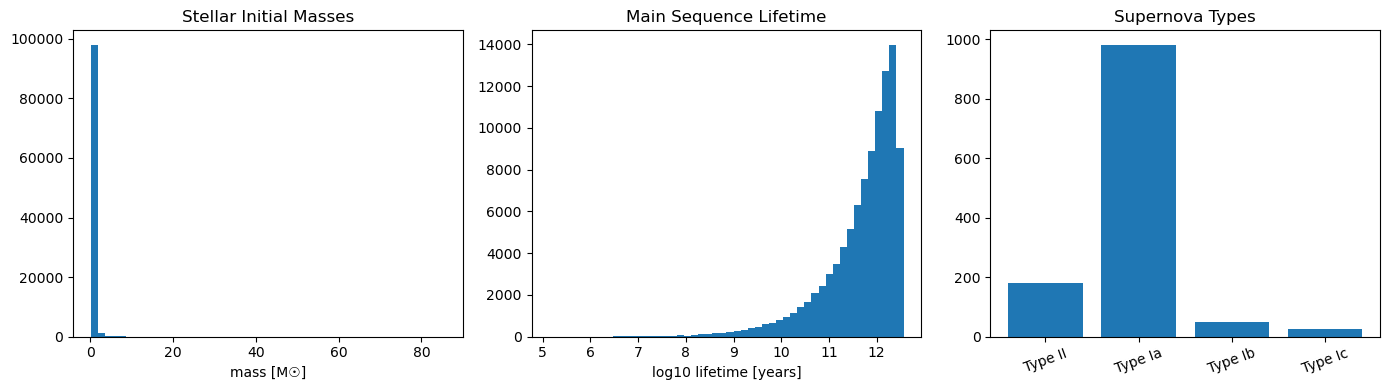

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(masses, bins=50)
plt.xlabel("mass [M☉]")
plt.title("Stellar Initial Masses")

plt.subplot(1,3,2)
plt.hist(np.log10(lifetimes), bins=50)
plt.xlabel("log10 lifetime [years]")
plt.title("Main Sequence Lifetime")

plt.subplot(1,3,3)
plt.bar(unique, counts)
plt.title("Supernova Types")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

## How do the supernova rate and type distribution change depending on the initial conditions of a star population?

we will now look at how changing comparitive parameters can change our output
we will vary: maximum mass when sampling masses
we will see: rare core-collapse sn will happen more often?

(other interesting parameters we did not choose: varying binary fraction, IMF-function, distribution of metallicity, ia-efficiancy)

one single mc-realisation:

In [61]:
from src.mc_functions import run_single_mc, mc_statistics


In [62]:
N = 100000
n_realizations = 100

m_max_values = [30, 50, 80, 120]

comparison_results = {}

for m_max in m_max_values:
    stats = mc_statistics(N=N, m_max=m_max, n_realizations=n_realizations)
    comparison_results[m_max] = stats


NameError: name 'is_typeIa_SN' is not defined